In [ ]:
# localization.ipynb
!pip install ultralytics opencv-python matplotlib

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from PIL import Image

In [3]:
# Load YOLO model
yolo_model = YOLO('yolo11m.pt')

In [4]:

# Load the kidney stone classification model
classification_model = load_model('../kidney_stone_detection_model.h5')

In [5]:
# Preprocessing for YOLO
def preprocess_image_yolo(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [6]:
# Preprocessing for the classification model
def preprocess_image_classification(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [40]:
def detect_and_localize(image_path):
    # Step 1: Use classification model for binary classification
    preprocessed_image = preprocess_image_classification(image_path)
    prediction = classification_model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction, axis=-1)

    if predicted_class[0] == 0:
        print("Prediction: Normal (No stone detected)")
        return None

    print("Prediction: Stone Detected")

    # Step 2: Use YOLO for localization
    img = preprocess_image_yolo(image_path)
    
    # Adjust confidence and IoU thresholds
    results = yolo_model.predict(img, conf=0.1, iou=0.3)  # Adjust these values

    # Create a copy of the image for highlighting
    highlighted_image = img.copy()
    detection_found = False  # Flag to check if any detection was made

    for result in results:
        for box in result.boxes:
                print("Box Coordinates:", box.xyxy.numpy())
                print("Confidence Score:", box.conf.numpy())

            # Get bounding box coordinates and confidence score
                x1, y1, x2, y2 = box.xyxy.numpy().astype(int).flatten()
                confidence = box.conf.numpy().item()

            # Filter detections based on confidence threshold
                if confidence > 0.1:  # Ensure only confident predictions are drawn
                   detection_found = True
                print(f"Detection: Coordinates=({x1}, {y1}, {x2}, {y2}), Confidence={confidence:.2f}")

                # Highlight the detected area by drawing a border
                highlighted_image = cv2.rectangle(
                    highlighted_image, (x1, y1), (x2, y2), (255, 0, 0), 5
                )
                cv2.putText(
                    highlighted_image, f"Stone: {confidence:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2
                )

    if not detection_found:
        print("No confident detection found, consider lowering the threshold.")
        plt.imshow(img)
        plt.title("Original Image (No Detection)")
        plt.axis("off")
        plt.show()
        return img

    # Display the highlighted image
    plt.figure(figsize=(12, 8))
    plt.imshow(highlighted_image)
    plt.axis("off")
    plt.show()

    return highlighted_image



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Prediction: Stone Detected

0: 640x640 1 orange, 1 clock, 889.9ms
Speed: 53.9ms preprocess, 889.9ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)
Box Coordinates: [[     6.0135      83.196      476.04      445.87]]
Confidence Score: [    0.41438]
Detection: Coordinates=(6, 83, 476, 445), Confidence=0.41
Box Coordinates: [[     134.12      184.23       187.5      269.27]]
Confidence Score: [    0.14311]
Detection: Coordinates=(134, 184, 187, 269), Confidence=0.14


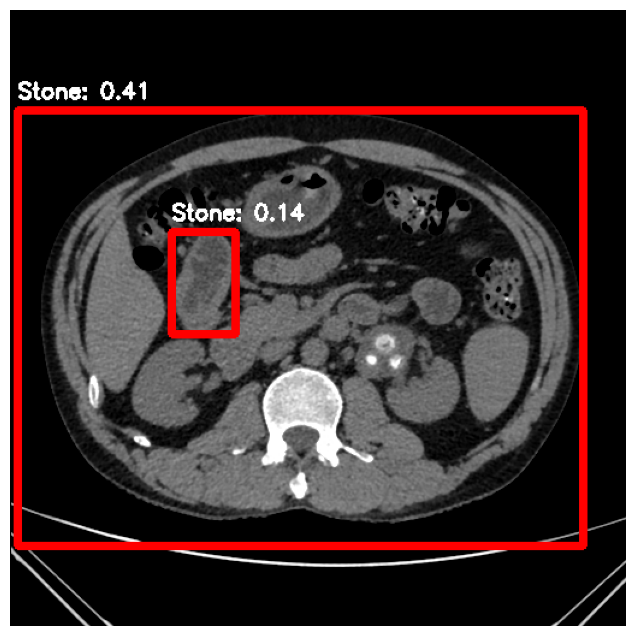

In [42]:
# Test with an image
test_image_path = "../dataset/test/Stone/Stone- (1046).jpg"
localized_image = detect_and_localize(test_image_path)


In [15]:

if localized_image is not None:
    output_path = "localized_output.jpg"
    cv2.imwrite(output_path, cv2.cvtColor(localized_image, cv2.COLOR_RGB2BGR))
    print(f"Localized image saved to {output_path}")

Localized image saved to localized_output.jpg
